# Import Data and Train Model


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision.transforms import ToTensor, Lambda
import torchvision.transforms as T
from transformers import get_scheduler, AdamW
from datasets import load_metric

import numpy as np
from scipy.io import wavfile
from scipy.fft import fft, fftfreq, fftshift
from scipy.fftpack import dct
import IPython.display
import librosa
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import pandas as pd;
import numpy as np
import math

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import mne
import mne.channels
from tqdm.auto import tqdm


c:\Users\loicl\Documents\UniWork\Year 3\Dissertation\TinyML-for-Epileptic-Seizures\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data: Create Dataset


### Load Absence Seizure Data


In [2]:
class AbsenceDataset(Dataset):
    def __init__(self, file_path, transform=None, target_transform=None):
        self.x, self.y = self.data_get(file_path)
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

    def data_get(self, file_path):
        data = pd.read_csv(file_path)
        x_loaded, y_loaded = [], []
        for index, row in data.iterrows():
            a = np.load(row["labels"])
            for i, v in enumerate(a):
                a[i] = int(v)
            y_loaded.append(a)

            x_loaded.append(np.load(row["data"]))

        continuous_x = np.concatenate(x_loaded, axis=0)
        continuous_y = np.concatenate(y_loaded, axis=0)

        return continuous_x, continuous_y

In [3]:
%%capture
# Load the dataset
dataset = AbsenceDataset(
    "processed_data/absence/five_channels_il_075/epochs_files.csv",
    transform=torch.tensor,
    target_transform=torch.tensor,
)
dataset.y = dataset.y.astype(int)

In [4]:
dataset.x.shape

(4141, 11, 1000)

# Split Data

70%, 20%, 10%


In [5]:
dataset_len = len(dataset)
dataset_len

4141

In [6]:
if (
    int(dataset_len * 0.7) + int(dataset_len * 0.2) + int(dataset_len * 0.1)
) != dataset_len:
    train_set, eval_set, test_set = random_split(
        dataset,
        [
            math.ceil(dataset_len * 0.7),
            int(dataset_len * 0.2),
            int(dataset_len * 0.1),
        ],
    )
else:
    train_set, eval_set, test_set = random_split(
        dataset,
        [
            int(dataset_len * 0.1),
            int(dataset_len * 0.7),
            int(dataset_len * 0.2),
        ],
    )

print(f"Train Split: {len(train_set)}")
print(f"Eval Split: {len(eval_set)}")
print(f"Test Split: {len(test_set)}")
print(f"Total: {len(train_set) + len(eval_set) + len(test_set)}")

Train Split: 2899
Eval Split: 828
Test Split: 414
Total: 4141


In [7]:
train_set.dataset.x[train_set.indices].shape, train_set.dataset.y[
    train_set.indices
].shape

((2899, 11, 1000), (2899,))

## Random Undersampling


In [8]:
bk, sz = 0, 0
for i, v in enumerate(train_set.dataset.y[train_set.indices]):
    if v == 1:
        sz += 1
    else:
        bk += 1

print(f"Background: {bk} // Absence Seizure: {sz}")

Background: 2784 // Absence Seizure: 115


In [9]:
shape = train_set.dataset.x[train_set.indices].shape
data_reshaped = train_set.dataset.x[train_set.indices]
data_reshaped = np.reshape(data_reshaped, (shape[0], shape[1] * shape[2]))
data_reshaped.shape

(2899, 11000)

In [10]:
rand_us = RandomUnderSampler(random_state=42)
train_set_x, train_set_y = rand_us.fit_resample(
    data_reshaped, train_set.dataset.y[train_set.indices]
)

In [11]:
train_set_x = np.reshape(train_set_x, (train_set_x.shape[0], shape[1], shape[2]))
val_set_x = eval_set.dataset.x[eval_set.indices]
train_set_x.shape, val_set_x.shape

((230, 11, 1000), (828, 11, 1000))

In [12]:
bk, sz = 0, 0
for i, v in enumerate(train_set_y):
    if v == 1:
        sz += 1
    else:
        bk += 1

print(f"Background: {bk} // Absence Seizure: {sz}")

Background: 115 // Absence Seizure: 115


# STFT


Create STFT


In [593]:
n_fft = int(1024 / 6)
window = "taylor"
hop_length = int(n_fft)

# Train
stft_channel_data = []
for i, channels in enumerate(train_set_x):
    stft_channel_data.append(
        (
            librosa.feature.melspectrogram(
                y=channels,
                sr=250,
                n_mels=4,
                n_fft=n_fft,
                fmin=0,
                fmax=4,
                hop_length=hop_length,
                window=window,
                center=True,
                pad_mode="reflect",
            )
        )
    )
stft_channel_data = np.array(stft_channel_data)

# Val
val_stft_channel_data = []
for i, channels in enumerate(val_set_x):
    val_stft_channel_data.append(
        (
            librosa.feature.melspectrogram(
                y=channels,
                sr=250,
                n_mels=4,
                n_fft=n_fft,
                fmin=0,
                fmax=5,
                hop_length=hop_length,
                window=window,
            )
        )
    )
val_stft_channel_data = np.array(val_stft_channel_data)

stft_channel_data.shape, val_stft_channel_data.shape

((230, 11, 4, 6), (828, 11, 4, 6))

In [594]:
# Train
train_db = []
for i, channels in enumerate(stft_channel_data):
    train_db.append(librosa.amplitude_to_db((channels), ref=np.max))
train_db = np.array(train_db)

# Val
val_db = []
for i, channels in enumerate(val_stft_channel_data):
    val_db.append(librosa.amplitude_to_db((channels), ref=np.max))
val_db = np.array(val_db)

train_db.shape, val_db.shape

((230, 11, 4, 6), (828, 11, 4, 6))

In [595]:
# Train
train_db_mean = []
for i, channels in enumerate(stft_channel_data):
    train_db_mean.append(np.mean(channels, axis=0))
train_db_mean = np.array(train_db_mean)

# Val
val_db_mean = []
for i, channels in enumerate(val_stft_channel_data):
    val_db_mean.append(np.mean(channels, axis=0))
val_db_mean = np.array(val_db_mean)

train_db_mean.shape, val_db_mean.shape

((230, 4, 6), (828, 4, 6))

AttributeError: QuadMesh.set() got an unexpected keyword argument 'center'

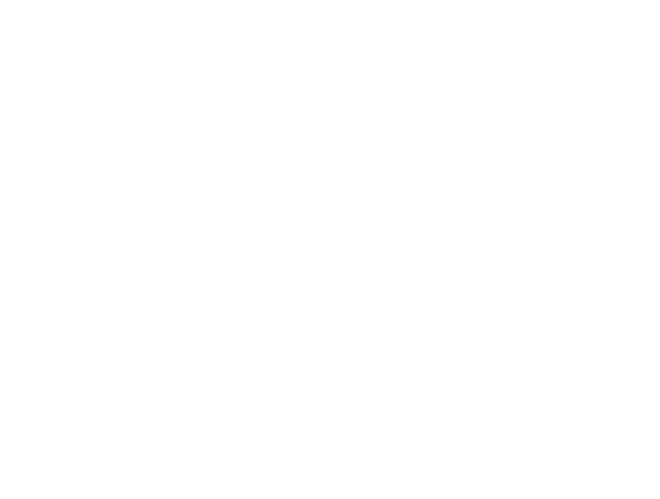

In [616]:
# %% capture
image_train = []
for i, data in enumerate(train_db_mean):
    f = plt.figure(frameon=False)
    ax = plt.Axes(f, [0.0, 0.0, 1.0, 1.0])
    ax.set_axis_off()
    f.add_axes(ax)
    img = librosa.display.specshow(data, sr=250, x_axis="time", y_axis="mel")
    plt.savefig("image_process.png")

    img = Image.open("image_process.png")
    img = img.resize((120, 160))
    image_train.append(img)
    plt.close("all")
image_train = np.array(image_train)

image_val = []
for i, data in enumerate(val_db_mean):
    f = plt.figure(frameon=False)
    ax = plt.Axes(f, [0.0, 0.0, 1.0, 1.0])
    ax.set_axis_off()
    f.add_axes(ax)
    img = librosa.display.specshow(data, sr=250, x_axis="time", y_axis="mel")
    plt.savefig("image_process.png")

    img = Image.open("image_process.png")
    img = img.resize((120, 160))
    image_val.append(img)
    plt.close("all")
image_val = np.array(image_val)

In [ ]:
image_train.shape, image_val.shape

((230, 160, 120, 4), (828, 160, 120, 4))

In [ ]:
fix_shape = []
for i, image in enumerate(image_train):
    image = image.transpose((2, 0, 1))
    fix_shape.append(image)
fix_shape = np.array(fix_shape)

fix_shape_val = []
for i, image in enumerate(image_val):
    image = image.transpose((2, 0, 1))
    fix_shape_val.append(image)
fix_shape_val = np.array(fix_shape_val)

image_train = fix_shape
image_val = fix_shape_val

fix_shape.shape, fix_shape_val.shape

((230, 4, 160, 120), (828, 4, 160, 120))

In [617]:
x = 166
print(image_train[0].shape)

a = image_train[x].transpose(1, 2, 0)
print(train_set_y[x])

Image.fromarray(a)

IndexError: list index out of range

Display STFT


# Remake Dataset


In [259]:
class BalancedDataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.x, self.y = data
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

In [260]:
new_balanced_train_dataset = BalancedDataset(
    (image_train, train_set_y), transform=torch.tensor, target_transform=torch.tensor
)
mfcc_eval_dataset = BalancedDataset(
    (image_val, eval_set.dataset.y[eval_set.indices]),
    transform=torch.tensor,
    target_transform=torch.tensor,
)

# Visualize Data


In [ ]:
# Plot 3 of each class
fig, axs = plt.subplots(2, 3, figsize=(20, 5))
fig.suptitle(
    "3 samples of each class: Absence Seizure and Background - Plotted as images with values scaled to 0-255"
)

c1 = 0
c0 = 0

for i, v in enumerate(train_set.dataset.y[train_set.indices]):
    if v == 0 and c0 < 3:
        clone = train_set.dataset.x[train_set.indices][i]
        max_pixel = 0
        min_pixel = 0
        for m, b in enumerate(clone):
            for j, n in enumerate(clone[m]):
                if n > max_pixel:
                    max_pixel = n
                if n < min_pixel:
                    min_pixel = n

        for m, b in enumerate(clone):
            for j, n in enumerate(clone[m]):
                a = clone[m][j] - min_pixel
                b = 255 / (max_pixel - min_pixel)
                norm = a * b
                if norm > 255:
                    norm = 255
                if norm < 0:
                    norm = 0
                clone[m][j] = norm

        # Increase image size for better visibility if needed
        clone = np.repeat(clone, 50, axis=0)

        axs[0, c0].imshow(clone, cmap="gray")
        axs[0, c0].set_title(f"Label 0: Background // Data Index: {i}")
        axs[0, c0].set_yticks([])
        axs[0, c0].set_xticks([0, 1000])
        axs[0, c0].set_xlabel("Data Points Per Window")

        c0 += 1

    if v == 1 and c1 < 3:
        clone = train_set.dataset.x[train_set.indices][i]
        max_pixel = 0
        min_pixel = 0

        for m, b in enumerate(clone):
            for j, n in enumerate(clone[m]):
                if n > max_pixel:
                    max_pixel = n
                if n < min_pixel:
                    min_pixel = n

        for m, b in enumerate(clone):
            for j, n in enumerate(clone[m]):
                a = clone[m][j] - min_pixel
                b = 255 / (max_pixel - min_pixel)
                norm = a * b
                if norm > 255:
                    norm = 255
                if norm < 0:
                    norm = 0
                clone[m][j] = norm

        # Increase image size for better visibility if needed
        clone = np.repeat(clone, 50, axis=0)

        axs[1, c1].imshow(clone, cmap="gray")
        axs[1, c1].set_title(f"Label 1: Absence Seizure // Data Index: {i}")
        axs[1, c1].set_yticks([])
        axs[1, c1].set_xticks([0, 1000])
        axs[1, c1].set_xlabel("Data Points Per Window")

        c1 += 1

    if c1 == 3 and c0 == 3:
        break

    # new_img = Image.fromarray(clone)

In [ ]:
# Plot 3 of each class
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle("3 samples of each class")
c0 = 0
c1 = 0
for i, v in enumerate(train_set.dataset.x[train_set.indices]):
    if c0 < 3 and train_set.dataset.y[train_set.indices][i] == 0:
        axs[0, c0].plot(train_set.dataset.x[train_set.indices][i][0], label="Channel 1")
        axs[0, c0].plot(train_set.dataset.x[train_set.indices][i][1], label="Channel 2")
        axs[0, c0].plot(train_set.dataset.x[train_set.indices][i][2], label="Channel 3")
        axs[0, c0].plot(train_set.dataset.x[train_set.indices][i][3], label="Channel 4")
        axs[0, c0].plot(train_set.dataset.x[train_set.indices][i][4], label="Channel 5")
        axs[0, c0].legend(loc="upper right")
        axs[0, c0].set_title(f"Label 0: Background // Data Index: {i}")
        c0 += 1
    elif c1 < 3 and train_set.dataset.y[train_set.indices][i] == 1:
        axs[1, c1].plot(train_set.dataset.x[train_set.indices][i][0], label="Channel 1")
        axs[1, c1].plot(train_set.dataset.x[train_set.indices][i][1], label="Channel 2")
        axs[1, c1].plot(train_set.dataset.x[train_set.indices][i][2], label="Channel 3")
        axs[1, c1].plot(train_set.dataset.x[train_set.indices][i][3], label="Channel 4")
        axs[1, c1].plot(train_set.dataset.x[train_set.indices][i][4], label="Channel 5")
        axs[1, c1].legend(loc="upper right")
        axs[1, c1].set_title(f"Label 1: Absence Seizure // Data Index: {i}")
        c1 += 1

    if c0 == 3 and c1 == 3:
        break
plt.show()

In [ ]:
# Plot 3 of each class
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle("3 samples of each class")
c0 = 0
c1 = 0
for i, v in enumerate(x_train_reshaped):
    if c0 < 3 and train_set.dataset.y[train_set.indices][i] == 0:
        axs[0, c0].plot(x_train_reshaped[i])
        axs[0, c0].set_title(f"Label 0: Background // Data Index: {i}")
        c0 += 1
    elif c1 < 3 and train_set.dataset.y[train_set.indices][i] == 1:
        axs[1, c1].plot(x_train_reshaped[i])
        axs[1, c1].set_title(f"Label 1: Absence Seizure // Data Index: {i}")
        c1 += 1

    if c0 == 3 and c1 == 3:
        break
plt.show()

# DataLoaders


In [261]:
train_dataloader = DataLoader(
    dataset=new_balanced_train_dataset,
    batch_size=1,
    shuffle=True,
)
eval_dataloader = DataLoader(dataset=mfcc_eval_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_set, batch_size=1, shuffle=True)

# Model


## Model 1: CNN


### 1D Model


In [341]:
class AbnormalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Input 5 Channels
        self.CNN1 = nn.Conv1d(in_channels=13, out_channels=20, kernel_size=3)
        self.MaxPool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.CNN2 = nn.Conv1d(in_channels=20, out_channels=60, kernel_size=3)
        self.MaxPool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.CNN3 = nn.Conv1d(in_channels=60, out_channels=1, kernel_size=2)
        self.MaxPool3 = nn.MaxPool1d(kernel_size=2, stride=1)

        # RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x38 and 6x100)
        self.fc1 = nn.Linear(in_features=38, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=50)
        self.output = nn.Linear(in_features=50, out_features=1)

    def forward(self, x):
        x = F.relu(self.CNN1(x))
        x = self.MaxPool1(x)

        x = F.relu(self.CNN2(x))
        x = self.MaxPool2(x)

        x = F.relu(self.CNN3(x))
        x = self.MaxPool3(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x


# Set device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = AbnormalNeuralNetwork().to(device)

# Set optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Calculate number of parameters in model
n_params = 0
for x in model.parameters():
    n_params += len(torch.flatten(x))
print(f"Number of parameters in model: {n_params:,}")

# Print Model
model = model.to(device)

Number of parameters in model: 13,582


### 2D Model


In [190]:
class AbnormalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Input 5 Channels
        self.CNN1 = nn.Conv2d(
            in_channels=4, out_channels=64, kernel_size=3, padding=(1, 0)
        )
        self.MaxPool1 = nn.MaxPool2d(kernel_size=(6, 6), stride=2)

        self.CNN2 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, padding=(1, 0)
        )
        self.MaxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.CNN3 = nn.Conv2d(
            in_channels=128, out_channels=1, kernel_size=3, padding=(1, 0)
        )
        self.MaxPool3 = nn.MaxPool2d(kernel_size=(1, 1), stride=2)

        # RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x260 and 5043x1024)
        self.fc1 = nn.Linear(260, 1024)
        # self.dropout1 = nn.Dropout(p=0.3)

        self.fc2 = nn.Linear(1024, 1024)
        # self.dropout2 = nn.Dropout(p=0.3)

        # Output Layer
        self.output = nn.Linear(in_features=1024, out_features=1)

    def forward(self, x):
        x = F.relu(self.CNN1(x))
        x = self.MaxPool1(x)

        x = F.relu(self.CNN2(x))
        x = self.MaxPool2(x)

        x = F.relu(self.CNN3(x))
        x = self.MaxPool3(x)

        x = torch.flatten(x)

        x = F.relu(self.fc1(x))

        x = F.relu(self.fc2(x))

        x = self.output(x)
        x = F.relu(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = AbnormalNeuralNetwork().to(device)

# Calculate number of parameters in model
n_params = 0
for x in model.parameters():
    n_params += len(torch.flatten(x))
print(f"Number of parameters in model: {n_params:,}")

# Print Model
model = model.to(device)
model

Number of parameters in model: 1,395,266


AbnormalNeuralNetwork(
  (CNN1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 0))
  (MaxPool1): MaxPool2d(kernel_size=(6, 6), stride=2, padding=0, dilation=1, ceil_mode=False)
  (CNN2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 0))
  (MaxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (CNN3): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 0))
  (MaxPool3): MaxPool2d(kernel_size=(1, 1), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=260, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (output): Linear(in_features=1024, out_features=1, bias=True)
)

### 2D Model 2: CNN


In [369]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=10)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=10)
        self.global_avg = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(128, 164)
        self.fc2 = nn.Linear(164, 164)
        self.fc3 = nn.Linear(164, 1)

    def forward(self, out):
        out = self.pool(F.relu(self.conv1(out)))
        out = self.pool(F.relu(self.conv2(out)))
        out = self.pool(F.relu(self.conv3(out)))
        out = self.global_avg(out)
        out = torch.flatten(out)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = Net().to(device)

# Calculate number of parameters in model
n_params = 0
for x in model.parameters():
    n_params += len(torch.flatten(x))
print(f"Number of parameters in model: {n_params:,}")

# Print Model
model = model.to(device)
model

Number of parameters in model: 1,085,405


Net(
  (conv1): Conv2d(4, 32, kernel_size=(10, 10), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(10, 10), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(10, 10), stride=(1, 1))
  (global_avg): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=164, bias=True)
  (fc2): Linear(in_features=164, out_features=164, bias=True)
  (fc3): Linear(in_features=164, out_features=1, bias=True)
)

## Model 2: Linear


### 1


In [ ]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(39, 78)
        self.linear2 = nn.Linear(78, 78)
        self.output = nn.Linear(78, 1)

    def forward(self, out):
        out = F.relu(self.linear1(out))
        out = F.relu(self.linear2(out))
        out = self.output(out)
        return out


model = LinearRegression().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

n_params = 0
for x in model.parameters():
    n_params += len(torch.flatten(x))
print(f"Number of parameters in model: {n_params:,}")

### 2


# Train


## Training Loop


### Print Inputs


In [263]:
# Plot distribution of the dataset before balancing
# 0 - Background epoch
# 1 - Absence seizure epoch

bk = 0
sz = 0
for i, v in enumerate(train_dataloader):
    if v[1].squeeze() == torch.tensor([1.0]):
        sz += 1
    else:
        bk += 1

print(f"Train // Background: {bk} // Absence Seizure: {sz}")

bk = 0
sz = 0
for i, v in enumerate(eval_dataloader):
    if v[1].squeeze() == torch.tensor([1.0]):
        sz += 1
    else:
        bk += 1

print(f"Validation // Background: {bk} // Absence Seizure: {sz}")

Train // Background: 115 // Absence Seizure: 115
Validation // Background: 787 // Absence Seizure: 41


### Training


In [187]:
for i, v in enumerate(eval_dataloader):
    first_input = v[0]
    first_label = v[1]
    break

print(first_input.shape, first_label)

for i, v in enumerate(train_dataloader):
    first_input = v[0]
    first_label = v[1]
    break

print(first_input.shape, first_label)

torch.Size([1, 4, 160, 120]) tensor([0.])
torch.Size([1, 4, 160, 120]) tensor([1.])


In [265]:
num_epochs = 300
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
scheduler = get_scheduler(
    "linear",
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_epochs * len(train_dataloader),
)

In [370]:
progress_bar = tqdm(range(num_epochs * len(train_dataloader)))

loss_track = []
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in train_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.squeeze(0)

        # print(type(inputs))
        # numpy_inputs = inputs.cpu().detach().numpy()
        # image = numpy_inputs.transpose(1, 2, 0)
        # image = image.astype("uint8")
        # image = Image.fromarray(image)
        # image.show()
        # print(labels)
        # break

        optimizer.zero_grad()

        outputs = model(inputs)

        # outputs = outputs.squeeze(-1)  # Not needed for LR
        # outputs = outputs.squeeze(-1)  # Not needed for LR

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        scheduler.step()
        progress_bar.update(1)

    loss_track.append(loss)
    # break

print("Done")

  0%|          | 0/69000 [01:09<?, ?it/s]


Done


In [305]:
print(outputs_log[44])

tensor([-1.9973], device='cuda:0', grad_fn=<ViewBackward0>)


In [371]:
metric = load_metric("glue", "mrpc")
model.eval()
tp, fp, tn, fn = 0, 0, 0, 0
results_list = []
for batch in eval_dataloader:
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)

    inputs = inputs.squeeze(0)

    with torch.no_grad():
        outputs = model(inputs)
        outputs = outputs.squeeze(-1)  # Not needed for LR

    results_list.append(outputs)
    # print(outputs)
    if outputs > 0.5:
        if labels == 1:
            tp += 1
        else:
            fp += 1
    else:
        if labels == 0:
            tn += 1
        else:
            fn += 1

    # logits = outputs.logits
    # predictions = torch.argmax(logits, dim=-1)
    # metric.add_batch(predictions=outputs, references=labels)

# results = metric.compute()
for i, v in enumerate(eval_dataloader):
    if v[1].squeeze() == torch.tensor([1.0]):
        print(results_list[i])

c:\Users\loicl\Documents\UniWork\Year 3\Dissertation\TinyML-for-Epileptic-Seizures\.venv\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


tensor(0.3796, device='cuda:0')
tensor(0.3229, device='cuda:0')
tensor(0.3561, device='cuda:0')
tensor(0.3079, device='cuda:0')
tensor(0.3478, device='cuda:0')
tensor(0.3513, device='cuda:0')
tensor(0.3317, device='cuda:0')
tensor(0.3275, device='cuda:0')
tensor(0.3642, device='cuda:0')
tensor(0.3198, device='cuda:0')
tensor(0.3752, device='cuda:0')
tensor(0.3490, device='cuda:0')
tensor(0.3573, device='cuda:0')
tensor(0.3578, device='cuda:0')
tensor(0.4532, device='cuda:0')
tensor(0.3577, device='cuda:0')
tensor(0.3466, device='cuda:0')
tensor(0.3024, device='cuda:0')
tensor(0.2859, device='cuda:0')
tensor(0.3214, device='cuda:0')
tensor(0.3561, device='cuda:0')
tensor(0.3557, device='cuda:0')
tensor(0.3567, device='cuda:0')
tensor(0.3277, device='cuda:0')
tensor(0.3671, device='cuda:0')
tensor(0.3228, device='cuda:0')
tensor(0.3507, device='cuda:0')
tensor(0.3332, device='cuda:0')
tensor(0.3740, device='cuda:0')
tensor(0.3930, device='cuda:0')
tensor(0.3372, device='cuda:0')
tensor(0

In [372]:
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"True Negatives: {tn}")
print(f"False Negatives: {fn}")
print(results_list)
# Plot schedular graph

True Positives: 0
False Positives: 0
True Negatives: 787
False Negatives: 41
[tensor(0.3467, device='cuda:0'), tensor(0.3404, device='cuda:0'), tensor(0.3549, device='cuda:0'), tensor(0.3458, device='cuda:0'), tensor(0.3343, device='cuda:0'), tensor(0.3309, device='cuda:0'), tensor(0.3506, device='cuda:0'), tensor(0.3133, device='cuda:0'), tensor(0.3479, device='cuda:0'), tensor(0.3609, device='cuda:0'), tensor(0.3611, device='cuda:0'), tensor(0.3495, device='cuda:0'), tensor(0.4138, device='cuda:0'), tensor(0.3857, device='cuda:0'), tensor(0.3482, device='cuda:0'), tensor(0.3357, device='cuda:0'), tensor(0.3575, device='cuda:0'), tensor(0.4087, device='cuda:0'), tensor(0.3451, device='cuda:0'), tensor(0.3289, device='cuda:0'), tensor(0.3691, device='cuda:0'), tensor(0.3707, device='cuda:0'), tensor(0.3654, device='cuda:0'), tensor(0.3586, device='cuda:0'), tensor(0.3551, device='cuda:0'), tensor(0.3562, device='cuda:0'), tensor(0.3591, device='cuda:0'), tensor(0.3327, device='cuda:0')

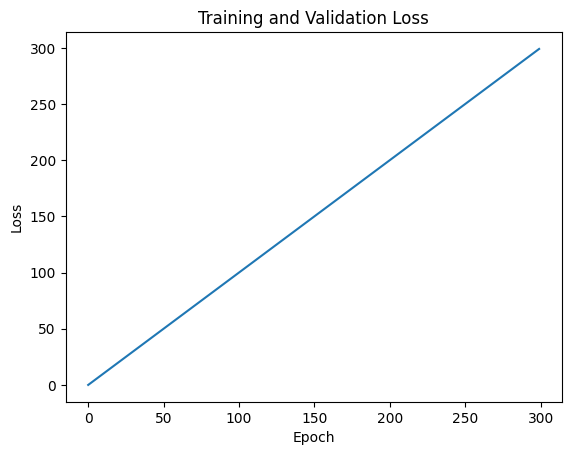

In [373]:
# Plot losses
a = []
for i in range(len(loss_track)):
    a.append(i)

plt.plot(range(len(a)), a, label="Training Loss")

# plt.plot(range(len(loss_track_valid)), loss_track_valid, label="Validation Loss")


plt.title("Training and Validation Loss")

plt.xlabel("Epoch")

plt.ylabel("Loss")


plt.show()

In [ ]:
torch.save(model.state_dict(), "model_{}".format("first_test"))